# SageMaker Ground Truth and Object Detection
## Workshop Guide

### Table of contents
1. [Introduction to dataset](#introduction)
2. [Labeling with SageMaker Ground Truth](#groundtruth)
3. [Reviewing labeling results](#review)
4. [Training an Object Detection model](#training)
5. [Review of Training Results](#review_training)
6. [Model Tuning](#model_tuning)
7. [Cleanup](#cleanup)


### Bootstrap embedded images

Download images used in the rest of this guide

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
BUCKET = sess.default_bucket()
PREFIX = 'input'

arn:aws:iam::460760493890:role/service-role/AmazonSageMaker-ExecutionRole-20210211T094368
CPU times: user 807 ms, sys: 152 ms, total: 959 ms
Wall time: 972 ms


Then reload the notebook (close/reopen for JupyterLab) so that the instruction images in the rest of this notebook become visible.

<a name="introduction"></a>
## Introduction to dataset
In this workshop we will use a dataset from the [inaturalist.org](inaturalist.org) This dataset contains 500 images of bees that have been uploaded by inaturalist users for the purposes of recording the observation and identification. We only used images that their users have licensed under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) license. For your convenience, we have placed the dataset in S3 in a single zip archive here: http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 

First, download and unzip the archive.

In [3]:
!wget http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 
!unzip -qo dataset.zip

--2021-04-20 17:48:28--  http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip
Resolving aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)... 52.218.144.81
Connecting to aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)|52.218.144.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70375947 (67M) [application/x-zip-compressed]
Saving to: ‘dataset.zip.1’

dataset.zip.1       100%[===================>]  67.12M  6.28MB/s    in 12s     

2021-04-20 17:48:41 (5.66 MB/s) - ‘dataset.zip.1’ saved [70375947/70375947]



The archive contains the following structure: 500 `.jpg` image files, a manifest file (to be explained later) and 10 test images in the `test` subfolder.

In [4]:
!unzip -l dataset.zip | tail -20

   251027  05-15-2019 19:21   9530124.jpg
   110561  05-15-2019 19:21   9542264.jpg
   312354  05-15-2019 19:21   9543188.jpg
    76903  05-15-2019 19:21   9637165.jpg
    48663  05-15-2019 19:21   9765741.jpg
    66393  05-15-2019 19:21   9787032.jpg
   273392  05-22-2019 21:58   output.manifest
        0  06-01-2019 05:51   test/
    83438  06-01-2019 05:51   test/22427594.jpg
   152133  06-01-2019 05:51   test/22469656.jpg
   205930  06-01-2019 05:51   test/22544384.jpg
   137755  06-01-2019 05:51   test/22673445.jpg
   124565  06-01-2019 05:51   test/22741822.jpg
    39502  06-01-2019 05:51   test/22774999.jpg
    39086  06-01-2019 05:51   test/22775000.jpg
   149389  06-01-2019 05:51   test/22901964.jpg
   103322  06-01-2019 05:51   test/22971237.jpg
   109178  06-01-2019 05:51   test/23086755.jpg
---------                     -------
 70635014                     512 files


Now let's upload this dataset to your own S3 bucket in preparation for labeling and training using Amazon SageMaker. For this workshop we will be using `us-west-2` region, so your bucket needs to be in this region. 

In [5]:
!aws s3 sync --exclude="*" --include="[0-9]*.jpg" . s3://$BUCKET/$PREFIX/

## Reviewing labeling results
<a name="reviewing"></a>

**WARNING: Pick OPTION 1 or OPTION 2 cells below**

If your labeling job has not finished (in case you chose the Public workforce), we can review results of the previously completed labeling job called ```bees-500``` using the provided augmented manifest file ```output.manifest```. In that case run OPTION 1 cell below and skip OPTION 2. Otherwise, skip OPTION 1 and run OPTION 2 to use results of your own labeling job.

In [6]:
###########
# OPTION 1: provided labeling results
###########
labeling_job_name = 'bees-500'
augmented_manifest_file = 'output.manifest'

Let's see the first few lines of the manifest file

In [7]:
#replacing bucket name and prefix to right format
outputManifest = open("output.manifest", "rt")
#read file contents to string
manifest = outputManifest.read()
#replace all occurrences of the required string
replaceStr = BUCKET + '/' + PREFIX
manifest = manifest.replace('sagemaker-remars/datasets/na-bees/500', replaceStr)
#close the input file
outputManifest.close()
#open the input file in write mode
outputManifest = open("output.manifest", "wt")
#overrite the input file with the resulting data
outputManifest.write(manifest)
#close the file
outputManifest.close()

In [8]:
!head -3 $augmented_manifest_file

{"source-ref":"s3://sagemaker-us-east-1-460760493890/input/10006450.jpg","bees-500":{"annotations":[{"class_id":0,"width":95.39999999999998,"top":256.2,"height":86.80000000000001,"left":177}],"image_size":[{"width":500,"depth":3,"height":500}]},"bees-500-metadata":{"job-name":"labeling-job/bees-500","class-map":{"0":"bee"},"human-annotated":"yes","objects":[{"confidence":0.75}],"creation-date":"2019-05-16T00:15:58.914553","type":"groundtruth/object-detection"}}
{"source-ref":"s3://sagemaker-us-east-1-460760493890/input/10022723.jpg","bees-500":{"annotations":[{"class_id":0,"width":93.8,"top":228.8,"height":135,"left":126.8}],"image_size":[{"width":375,"depth":3,"height":500}]},"bees-500-metadata":{"job-name":"labeling-job/bees-500","class-map":{"0":"bee"},"human-annotated":"yes","objects":[{"confidence":0.82}],"creation-date":"2019-05-16T00:41:33.384412","type":"groundtruth/object-detection"}}
{"source-ref":"s3://sagemaker-us-east-1-460760493890/input/10059108.jpg","bees-500":{"annotat

Now let's plot all the annotated images. First, let's define a function that displays the local image file and draws over it the bounding boxes obtained via labeling.

In [9]:
import os
import boto3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle

def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Next, read the augmented manifest (JSON lines format) line by line and display the first 10 images.

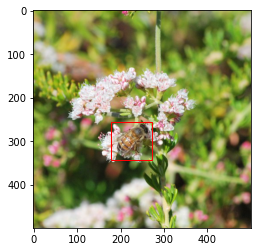

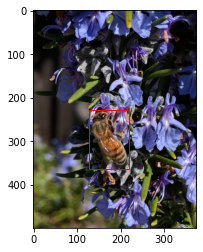

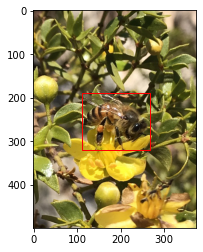

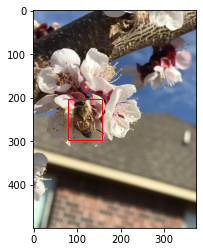

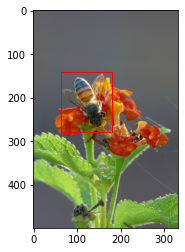

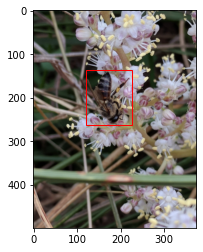

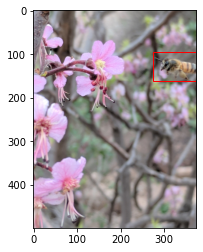

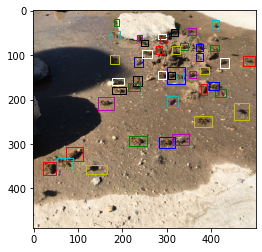

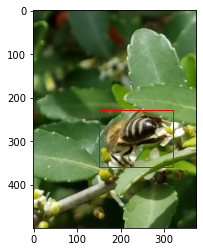

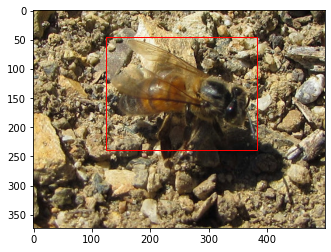

In [10]:
!pip -q install --upgrade pip
!pip -q install jsonlines
import jsonlines
from itertools import islice

with jsonlines.open(augmented_manifest_file, 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref']
        img_file = os.path.basename(img_url)
        file_exists = os.path.isfile(img_file)

        bboxes = desc[labeling_job_name]['annotations']
        show_annotated_image(img_file, bboxes)

<a name='training'></a>
## Training an Object Detection Model
We are now ready to use the labeled dataset in order to train a Machine Learning model using the SageMaker [built-in Object Detection algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

For this, we would need to split the full labeled dataset into a training and a validation datasets. Out of the total of 500 images we are going to use 400 for training and 100 for validation. The algorithm will use the first one to train the model and the latter to estimate the accuracy of the model, trained so far. The augmented manifest file from the previously run full labeling job was included in the original zip archive as `output.manifest`.

In [11]:
import json

with jsonlines.open('output.manifest', 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.8)

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = 'train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')

training samples: 400, validation samples: 100


Next, let's upload the two manifest files to S3 in preparation for training. We will use the same bucket you created earlier.

In [12]:
pfx_training = PREFIX + '/training' if PREFIX else 'training'

# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)

!aws s3 cp train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp validation.manifest s3://$BUCKET/$pfx_training/

upload: ./train.manifest to s3://sagemaker-us-east-1-460760493890/input/training/train.manifest
upload: ./validation.manifest to s3://sagemaker-us-east-1-460760493890/input/training/validation.manifest


To check the progess of the training job, you can refresh the console or repeatedly evaluate the following cell. When the training job status reads `'Completed'`, move on to the next part of the tutorial.

In [ ]:
#s3_train_data_path

In [19]:
# Create a train and validation data channel with S3_data_type as 'AugmentedManifestFile' and attribute names.
training_data = sagemaker.session.s3_input(s3_train_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'bees-500'],
                                        record_wrapping='RecordIO')


validation_data = sagemaker.session.s3_input(
                                        s3_validation_data_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-recordio',
                                        s3_data_type='AugmentedManifestFile',
                                        attribute_names=['source-ref', 'bees-500'],
                                        record_wrapping='RecordIO')

data_channels = {'train': training_data, 'validation': validation_data}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [20]:
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(boto3.Session().region_name, 'object-detection')


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [21]:
s3_output_location = 's3://{}/model/output'.format(BUCKET)

In [22]:
od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         input_mode = 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [23]:
#https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             epochs=100,
                             learning_rate=0.001,
                             lr_scheduler_factor=0.1,
                             lr_scheduler_step='',
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             mini_batch_size=1,
                             image_shape='300',
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             num_training_samples=400,
                             early_stopping='True',
                             early_stopping_min_epochs=50,
                             early_stopping_patience = 5,
                             early_stopping_tolerance =0.01
                            )


In [24]:
od_model.fit(inputs=data_channels, logs=True)


2021-04-20 18:09:27 Starting - Starting the training job...
2021-04-20 18:09:51 Starting - Launching requested ML instancesProfilerReport-1618942166: InProgress
......
2021-04-20 18:10:51 Starting - Preparing the instances for training.........
2021-04-20 18:12:22 Downloading - Downloading input data
2021-04-20 18:12:22 Training - Downloading the training image......
2021-04-20 18:13:27 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[04/20/2021 18:13:30 INFO 140487625290944] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'

In [32]:
od_model._current_job_name

'object-detection-2021-04-20-18-09-26-953'

In [33]:
import boto3
client = boto3.client('sagemaker')

##### REPLACE WITH YOUR OWN TRAINING JOB NAME
# In the above console screenshots the job name was 'bees-detection-resnet'.
# But if you used Python to kick off the training job,
# then 'training_job_name' is already set, so you can comment out the line below.
#training_job_name = 'bees-detection-resnet'

training_job_name = od_model._current_job_name

##### REPLACE WITH YOUR OWN TRAINING JOB NAME




training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])

Training job status:  Completed
Secondary status:  Completed


<a name='review_training'></a>

## Review of Training Results

First, let's create the SageMaker model out of model artifacts

### Create Endpoint

The next cell creates an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [35]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')


-----------------!

### Perform inference

We will invoke the deployed endpoint to detect bees in the 10 test images that were inside the `test` folder in `dataset.zip` which you downloaded at the beginning of the workshop.

In [36]:
import glob
test_images = glob.glob('test/*')
print(*test_images, sep="\n")

test/22774999.jpg
test/22741822.jpg
test/23086755.jpg
test/22469656.jpg
test/22673445.jpg
test/22427594.jpg
test/22544384.jpg
test/22901964.jpg
test/22775000.jpg
test/22971237.jpg


Next, define a function that converts the prediction array returned by our endpoint to the bounding box structure expected by our image display function.

In [38]:
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

Finally, for each of the test images, the following cell transforms the image into the appropriate format for realtime prediction, repeatedly calls the endpoint, receives back the prediction, and displays the result.

In [41]:
object_detector.endpoint_name

'object-detection-2021-04-20-18-49-18-619'

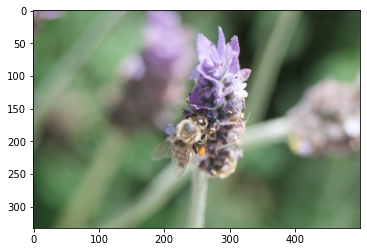

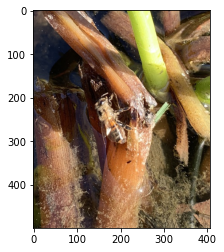

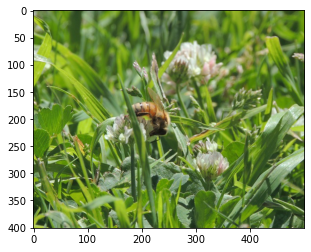

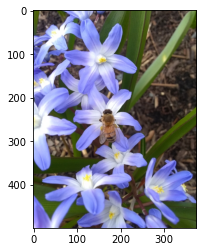

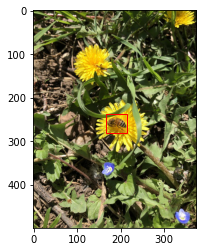

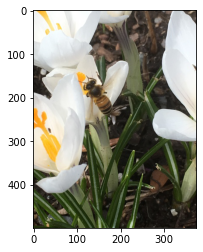

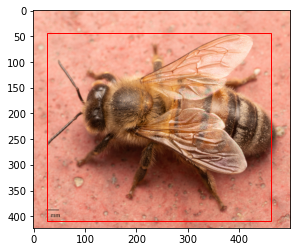

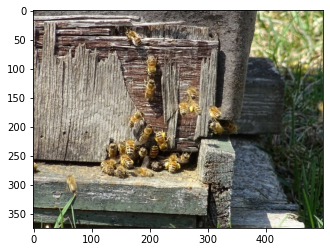

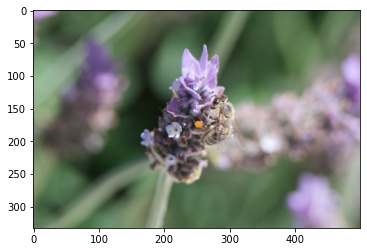

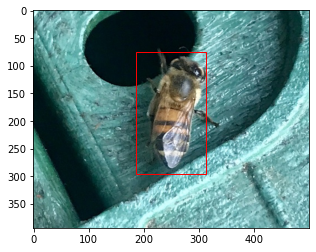

In [42]:
import matplotlib.pyplot as plt



endpoint_name= object_detector.endpoint_name

runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .5
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)

<a name='cleanup'></a>
## Cleanup

At the end of the lab we would like to delete the real-time endpoint, as keeping a real-time endpoint around while being idle is costly and wasteful. 

In [ ]:
client.delete_endpoint(EndpointName=endpoint_name)